In [106]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import OrderedDict
from multiprocessing import Pool
from numba import jit
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa import arima_process
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
from statsmodels import tsa

sns.set_context("paper", font_scale=1.7)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

# Import Data

In [107]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    # Magic number for the number of observations each file should have
    if len(ticker_df) == 1447:
        ticker_dfs.append(ticker_df)

data_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 2.55 s, sys: 3.88 s, total: 6.42 s
Wall time: 6.83 s


# Clean Data

## Additional Vars

In [108]:
data_rv_df['1'] = 1
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])

## Lagged Measures

In [109]:
data_rv_df = data_rv_df.sort_values(by = ['ticker', 'date'])

# Signed Jump variants
data_rv_df['sgn_jump_var_pos'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] > 0)
data_rv_df['sgn_jump_var_neg'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] < 0)

data_rv_df['rq'] = data_rv_df['return_p4']/3
data_rv_df['sqrt_rq'] = np.sqrt(data_rv_df['rq'])

data_rv_df['year'] = data_rv_df['date'].dt.year

In [110]:
# Lags
data_rv_df["rv_d_lag_1"] = data_rv_df["return_d_p2"].shift(1)
data_rv_df["rv_d_lag_m5"] = data_rv_df["rv_lag_1"].rolling(5).mean()
data_rv_df["rv_d_lag_m22"] = data_rv_df["rv_lag_1"].rolling(22).mean()

In [111]:
lag_coeff_cols = [
    "return_j_pos",
    "return_j_neg",
    "return_d_pos",
    "return_d_neg",
    "sum_jump_p2_1",
    "sum_jump_p2_5",
    "sum_jump_p2_22",
    "sum_jump_p2_pos_1",
    "sum_jump_p2_pos_5",
    "sum_jump_p2_pos_22",
    "sum_jump_p2_neg_1",
    "sum_jump_p2_neg_5",
    "sum_jump_p2_neg_22",
    "sgn_jump_var",
    "sgn_jump_var_pos",
    "sgn_jump_var_neg",
    "sqrt_rq",
]

interact_cols = [
    "rv_lag_1",
    "rv_lag_m5",
    "rv_lag_m22",
    "rv_d_lag_1",
    "rv_d_lag_m5",
    "rv_d_lag_m22",
]

for col in tqdm(lag_coeff_cols):
    data_rv_df[col + "_lag_1"] = data_rv_df.groupby("ticker")[col].shift(1)

    for icol in interact_cols:
        data_rv_df[f"{icol}:{col}_lag_1"] = np.multiply(
            data_rv_df[icol], data_rv_df[col + "_lag_1"]
        )

# Rolling Beta

In [112]:
# Window length
window = 66
lags = 22
len(ticker_rv_df['rv'])

1447

In [113]:
def spectral_rad(data):
    
    fit_params = tsa.ar_model.AutoReg(np.array(data), lags).fit().params
    
    Phi = np.eye(lags)
    Phi = np.c_[Phi, np.zeros((lags,1))]
    Phi = np.vstack((fit_params, Phi))
    eigvals, eigvecs = np.linalg.eig(Phi)
    spectral_rad = np.linalg.norm(np.max(eigvals))
    
    return spectral_rad

In [114]:
tickers_rv_df = data_rv_df.query('ticker in ["AAPL"]').copy().reset_index(drop = True)
tickers_rv_df['spectral_rad'] = tickers_rv_df['rv'].rolling(66).apply(lambda x: spectral_rad(x))

<AxesSubplot:xlabel='date', ylabel='spectral_rad'>

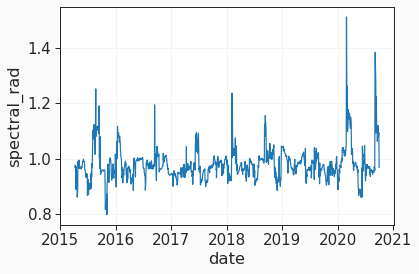

In [115]:
sns.lineplot(x = 'date', y = 'spectral_rad', data = tickers_rv_df)

In [198]:
lags = 22
def tsls_pers(data):
    x = np.array(data)
    newz = tsa.ar_model.AutoReg(x, lags).fit().predict()
    x = x[(lags):]
#     display(np.shape(x), np.shape(newz))
    persistence = ((newz.T @ x)**(-1)) * (newz[:-1].T @ x[1:])
    
    return persistence

In [199]:
for i in range(10):
    tickers_rv_df[f'rv_{i+1}'] = tickers_rv_df['rv'].shift(i+1)


tickers_rv_df['persistence'] = tickers_rv_df['rv'].rolling(66).apply(lambda x: tsls_pers(x))

<AxesSubplot:xlabel='date', ylabel='persistence'>

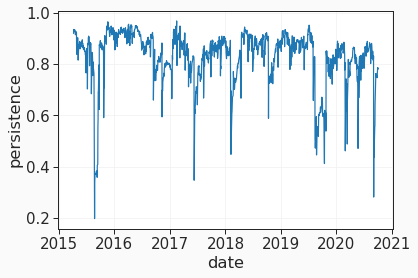

In [200]:
sns.lineplot(x = 'date', y = 'persistence', data = tickers_rv_df)

In [154]:
np.shape(z[:-1,:])

(1443, 3)

In [155]:
np.shape(x[1:])

(1443,)

0.8841548821395474

In [134]:
tsa.ar_model.AutoReg(x, 3).fit().params

array([4.35030503e-05, 4.09666776e-01, 3.10673816e-01, 3.56915339e-02])

In [60]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + ['rv']]
        .dropna()
        .set_index('date')
    )
    
    sr_list = []
    
    for roll_shift in range(500):
        sr_list.append(spectral_rad(np.roll(reg_df['rv'].values, -1*roll_shift)[:66]))
    
    return sr_list

In [61]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers[:10]),
        total=len(tickers),
    ):
        results.append(fit_params_df)


CPU times: user 46.9 ms, sys: 766 ms, total: 812 ms
Wall time: 2.05 s


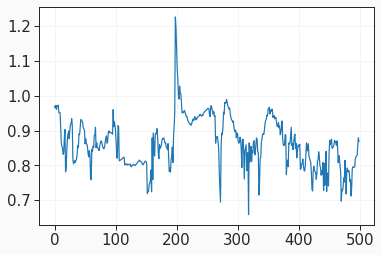

In [63]:
plt.plot(results[0])